# How to generate a digital elevation model (DEM) from a lidar point cloud in COPC LAZ format

This tutorial gives examples of how to generate a [digital elevation model](https://natural-resources.canada.ca/science-data/science-research/data-analysis/geospatial-data-portals-tools-services/elevation-data) from a lidar point cloud in the [Lidar Point Clouds - CanElevation Series](https://open.canada.ca/data/en/dataset/7069387e-9986-4297-9f55-0288e9676947) product. We will mainly use the [pdal](https://pdal.io/en/2.8.3/index.html) library to prepare the points and generate the raster grid.
More specifically, we will create a digital terrain model. This model is a raster grid in which each pixel represents a ground elevation value at that location.
This model is created in three distinct stages.

1. Read the points.
2. Filter the points to keep only those with soil class (class 2 and 9).
3. Generate a raster grid.

## Steps:

1) [Prepare the Environment](#1-prepare-the-environment)

2) [Import Necessary Modules](#2-import-necessary-modules)

3) [Define Variables](#3-define-variables)

4) [Define Methods](#4-define-methods)

5) [Filter Points in Preparation for DEM Creation](#5-filter-points-in-preparation-for-dem-creation)

6) [Create the DEM in GeoTIFF Format](#6-create-the-dem-in-geotiff-format)


## 1) Prepare the Environment

To run these examples locally, follow these steps:

### 1.1) Retrieve the Source Code

   In a directory of your choice on your computer, clone the repository using the following command:
   >```bash
   >git clone https://github.com/NRCan/CanElevation.git
   >```
   
   Then, navigate to the directory containing the notebooks:
   >```bash
   >cd CanElevation/docs/en/pointclouds
   >```

### 1.2) Install Conda (if needed)

   We recommend using conda to manage dependencies.
   
   If you haven't already installed it, refer to the official [Miniconda installation instructions](https://docs.anaconda.com/miniconda/install/#quick-command-line-install). The following steps assume conda is available from your command line.

### 1.3) Install Project Dependencies

   The `docs\assets\env\environment.yml` file lists all necessary dependencies. Create a new conda environment using the following command:
   >```bash
   >conda env create -n CanElevation_PointClouds --file docs/assets/env/environment.yml
   >```
   
   Then, activate the newly created environment:
   >```bash
   >conda activate CanElevation_PointClouds
   >```

### 1.4) Start Jupyter Notebook

   To start Jupyter Notebook, run:
   >```bash
   >jupyter notebook
   >```

If you encounter issues or want to explore more launch options, refer to the [Jupyter Notebook User Guide](https://jupyter-notebook-beginner-guide.readthedocs.io/en/latest/execute.html).

**You are now ready to run the code cells in the notebook.**

## 2) Import Necessary Modules

In the following example, we specifically use the [PDAL](https://pdal.io/en/2.8.4/) module to create the DEM. We also use the [matplotlib](https://matplotlib.org/stable/) and [rasterio](https://rasterio.readthedocs.io/en/stable/index.html) modules for visualization purposes.

In [2]:
import os
import json
import pdal
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## 3) Define Variables

For the example, we will use a lidar tile from the Niagara region in Ontario. To simplify processing, we define an encompassing polygon within this tile.

These variables can be adjusted as required. You can also use the product's [project index](https://canelevation-lidar-point-clouds.s3.ca-central-1.amazonaws.com/pointclouds_nuagespoints/Index_LiDARprojects_projetslidar.zip) and [tile index](https://canelevation-lidar-point-clouds.s3.ca-central-1.amazonaws.com/pointclouds_nuagespoints/Index_LiDARtiles_tuileslidar.zip) to select a different area of interest.

In [3]:
# URL to the COPC (Cloud Optimized Point Cloud) LAZ file from the Hamilton-Niagara 2021 lidar dataset
copc_laz = "https://canelevation-lidar-point-clouds.s3.ca-central-1.amazonaws.com/pointclouds_nuagespoints/NRCAN/Hamilton_Niagara_2021_2/ON_Niagara_20210525_NAD83CSRS_UTM17N_1km_E656_N4771_CLASS.copc.laz"

# Name of the local file to store all unfiltered points extracted from the COPC file
all_points_laz = "niagara_unfiltered_points.laz"

# Name of the local file to store only the ground/water-classified points extracted from the COPC file
ground_laz = "niagara_ground_points.laz"

# Area of interest (AOI) used to specifically filter the points; coordinates are in NAD83(CSRS) - UTM zone 17N (EPSG:2958)
aoi_bbox = {
    'minx': 656083,     # minimum X coordinate (easting)
    'miny': 4771150,    # minimum Y coordinate (northing)
    'maxx': 656722,     # maximum X coordinate (easting)
    'maxy': 4771614     # maximum Y coordinate (easting)
}

## 4) Define methods

We define several methods used to process the data.

*Consult each method's docstring for details on their functionality, arguments, and return values.*

In [13]:
# %load dem_from_copc_lidar_methods.py
def get_classification_name(
        code: int
    ) -> str:
    """
    [en] Retrieves standard lidar classification names from the code.
    [fr] Récupère le nom standard de la classe lidar à partir de son code.
    
    Parameters:
    -----------
    code : int
        [en] Classification code.
        [fr] Code de classification.
    
    Returns:
    --------
    str
        [en] Classification name.
        [fr] Nom de la classification.
    """
    # Dictionary mapping lidar classification codes their respective names
    classification_names = {
        0: "Created, never classified",
        1: "Unclassified / Non classifié",
        2: "Ground / Sol",
        3: "Low Vegetation / Basse végétation",
        4: "Medium Vegetation / Moyenne végétation",
        5: "High Vegetation / Haute Végétation",
        6: "Building / Bâtiments",
        7: "Low Point (noise) / Bruit bas",
        8: "Model Key-point",
        9: "Water / Eau",
        10: "Rail / Rail",
        # Add more codes if needed
    }
    return classification_names.get(code, f"Unknown ({code})")

def get_custom_color(
        class_code: int
    ) -> tuple:
    """
    [en] Provides custom colors for specific lidar classification codes.
    [fr] Fournit des couleurs personnalisées pour des codes de classification lidar spécifiques.
    
    Parameters:
    -----------
    class_code : int
        [en] Classification code.
        [fr] Code de classification.
    
    Returns:
    --------
    tuple
        [en] RGBA color.
        [fr] Couleur RGBA.
    """
    # Predefined custom colors (RGBA)
    custom_colors = {
        1: (0.5, 0.9, 0.5, 0.5),    # Light green for Unclassified
        2: (0.8, 0.4, 0.0, 0.5),    # Dark orange for Ground
        6: (1.0, 0, 0, 0.5)         # Red for Building
    }
    return custom_colors.get(class_code, None)

def create_read_pdal_pipeline(
        input_file: str,
        output_file: str,
        classes: list = None,
        bbox: dict = None
    ) -> pdal.Pipeline:
    """
    [en] Creates a PDAL pipeline to filter points by classification and bounding box.
    [fr] Crée un pipeline PDAL pour filtrer les points selon leurs classes et le polygone englobant.
    
    Parameters:
    -----------
    input_file : str
        [en] Path to the input point cloud file.
        [fr] Chemin vers le fichier de nuage de points en entrée.
    output_file : str
        [en] Path to save the filtered point cloud.
        [fr] Chemin pour sauvegarder le nuage de points filtré.
    classes : list
        [en] List of classification to keep.
        [fr] Liste des classes lidar à conserver.
    bbox : dict
        [en] Bounding box with min/max coordinates.
        [fr] Boîte englobante avec les coordonnées min/max.
    
    Returns:
    --------
    pdal.Pipeline
        [en] Configured PDAL pipeline.
        [fr] Pipeline PDAL configuré.
    """
    pipeline_json = {
        "pipeline": [
            {
                "type": "readers.las",
                "filename": input_file
            }
        ]
    }
    
    # Add cropping stage if bounding box is provided
    if bbox:
        pipeline_json['pipeline'].append({
            "type": "filters.crop",
            "bounds": f"([{bbox['minx']},{bbox['maxx']}],[{bbox['miny']},{bbox['maxy']}])"
        })
    
    # Filter by classification if specified
    if classes:
        expression = ''
        for class_code in classes:
            if expression:
                expression += f' || Classification == {class_code}'
            else:
                expression = f'Classification == {class_code}'
        
        pipeline_json['pipeline'].append({
            "type":"filters.expression",
            "expression":expression
        })
    
    # Write filtered points to output
    pipeline_json['pipeline'].append({
        "type": "writers.las",
        "filename": output_file
    })
    
    return pdal.Pipeline(json.dumps(pipeline_json))

def create_dem_pipeline(
        input_array: np.ndarray,
        output_filename: str = "dem.tif",
        resolution: float = 1.0,
        window_size: int = 6,
        output_type: str = "mean"
    ) -> pdal.pipeline:
    """
    [en] Creates a PDAL pipeline that creates a DEM from an array of points.
    [fr] Crée un pipeline PDAL produisant un MNE à partir d'une séquence de points.
    
    Parameters:
    -----------
    `input_array` :numpy.ndarray
        [en] Input point cloud array.
        [fr] Tableau de points en entrée.
    `output_filename` : str, optional
        [en] Output DEM filename.
            Defaults to 'dem.tif'.
        [fr] Nom du fichier MNE en sortie.
            Par défaut 'dem.tif'.
    `resolution` : float, optional
        [en] Output raster resolution in same units as input data.
            Defaults to 1.0.
        [fr] Résolution du raster de sortie (même unité que les données).
            Par défaut 1.0.
    `window_size` : int, optional
        [en] Number of pixels to consider when applying the output_type.
            Defaults to 6.
        [fr] Taille de la fenêtre utilisée pour le calcul statistique.
            Par défaut 6.
    `output_type` : str, optional
        [en] Statistic to use when creating the raster. Can be 'mean', 'min', 'max', 'idw', etc.
            Defaults to 'mean'.
        [fr] Statistique à appliquer pour créer le raster ('mean', 'min', 'max', 'idw', etc.).
            Par défaut 'mean'.
    
    Returns:
    --------
    pdal.Pipeline
        [en] Configured PDAL pipeline object ready to create a DEM.
        [fr] Objet pipeline PDAL configuré pour générer un MNE.
    """
    # Define the pipeline stages
    pipeline_def = {
        "pipeline": [
            {
                "type": "writers.gdal",
                "filename": output_filename,
                "output_type": output_type,
                "gdaldriver": "GTiff",
                "resolution": resolution,
                "window_size": window_size,
                "gdalopts": "COMPRESS=DEFLATE,PREDICTOR=2,TILED=YES",
                "nodata": -9999
            }
        ]
    }
    
    # Create pipeline and pass the input array directly
    return pdal.Pipeline(json.dumps(pipeline_def), arrays=[input_array])

def create_plot(
        title: str,
        pts_array: np.array,
        max_points: int = 25000
    ) -> plt:
    """
    [en] Creates a matplotlib 3D plot of lidar points colorized by classification.
    [fr] Crée un graphique 3D matplotlib des points lidar colorés selon leur classification.
    
    Parameters:
    -----------
    title : str
        [en] Title for the plot.
        [fr] Titre du graphique.
    pts_array : numpy.array
        [en] Points numpy array obtained from PDAL.
        [fr] Tableau de points obtenu avec PDAL.
    max_points : int
        [en] Maximum number of points to keep for the plot.
        [fr] Nombre maximum de points à afficher.
    
    Returns:
    --------
    matplotlib.pyplot
        [en] Configured plot object.
        [fr] Graphique matplotlib configuré.
    """
    # Downsample if array is too large
    if len(pts_array) > max_points:
        indices = np.random.choice(len(pts_array), max_points, replace=False)
        pts_array = pts_array[indices]
    
    # Extract coordinates and classifications
    x = pts_array['X']
    y = pts_array['Y']
    z = pts_array['Z']
    classifications = pts_array['Classification']
    
    # Create color map
    unique_classes = np.unique(classifications)
    color_map = plt.get_cmap('tab10')
    
    # Create 3D scatter plot
    fig = plt.figure(figsize=(15, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot points for each unique classification
    legend_labels = []
    legend_handles = []
    for class_code in unique_classes:
        mask = classifications == class_code
    
        color = get_custom_color(class_code)
        if not color:
            color = color_map(class_code / max(unique_classes))
        
        scatter = ax.scatter(
            x[mask], y[mask], z[mask], 
            c=[color], alpha=0.5, s=5, 
            label=get_classification_name(class_code)
        )
        legend_handles.append(scatter)
        legend_labels.append(get_classification_name(class_code))
    
    # Customize plot
    ax.set_xlabel('X',  fontsize=12)
    ax.set_ylabel('Y', fontsize=12)
    ax.set_zlabel('Z', fontsize=12)
    ax.set_title(title, fontsize=14)
    #ax.set_title('Point Cloud Colored by Classification')
    
    # Add legend
    ax.legend(legend_handles, legend_labels, title='Legend/Légende', loc='center left', bbox_to_anchor=(1.1, 0.5))
    
    plt.tight_layout()
    return plt

def plot_dem(
        dem_file: str,
        figsize: tuple = (10, 8),
        cmap: str = 'terrain',
        vmin: float = None,
        vmax: float = None
    ) -> tuple:
    """
    [en] Plots a DEM from a GeoTIFF file with proper elevation range handling.
    [fr] Affiche un MNE à partir d'un fichier GeoTIFF en tenant compte de la plage d'élévation.
    
    Parameters:
    -----------
    dem_file : str
        [en] Path to the DEM GeoTIFF file.
        [fr] Chemin vers le fichier MNE (GeoTIFF).
    figsize : tuple, optional
        [en] Size of the output figure in inches (width, height).
            Defaults to (10, 8).
        [fr] Dimensions du graphique (largeur, hauteur).
            Par défaut (10, 8).
    cmap : str, optional
        [en] Colormap used to represent elevation.
            Defaults to 'terrain'.
        [fr] Carte de couleurs utilisée pour l'affichage de l'altitude.
            Par défaut 'terrain'.
    vmin : float, optional
        [en] Minimum elevation value for color scaling.
            Defaults to None (i.e., data minimum).
        [fr] Valeur minimale d'altitude pour l'échelle.
            Par défaut : minimum des données.
    vmax : float, optional
        [en] Maximum elevation value for color scaling.
            Defaults to None (i.e., data maximum).
        [fr] Valeur maximale d'altitude pour l'échelle.
            Par défaut : maximum des données.
    
    Returns:
    --------
    tuple
        [en] Matplotlib figure and axis objects.
        [fr] Figure matplotlib.
    """
    # Read the DEM
    with rasterio.open(dem_file) as src:
        elevation = src.read(1)
        nodata = src.nodata
        
        # Get spatial extent
        bounds = src.bounds
        extent = [bounds.left, bounds.right, bounds.bottom, bounds.top]
        
        # Remove NoData values (usually very negative values)
        elevation = np.ma.masked_where(elevation == nodata, elevation)
        
        # If vmin/vmax are not provided, calculate from data
        if vmin is None:
            vmin = 75
        if vmax is None:
            vmax = np.nanmax(elevation)
    
    # Create figure and axis
    fig, ax = plt.subplots(figsize=figsize)
    im = ax.imshow(elevation, cmap=cmap, vmin=vmin, vmax=vmax, extent=extent, origin='upper')
    
    # Add a colorbar
    cbar = plt.colorbar(im, ax=ax, fraction=0.046, shrink=0.8, pad=0.04)
    cbar.set_label('Elevation')
    
    # Add vmin/vmax information to title
    ax.set_title(f'Digital Elevation Model\nElevation range: {vmin:.2f} to {vmax:.2f}')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    
    return fig, ax

<a id="filter-points"></a>
## 5) Filter Points in Preparation for DEM Creation

To prepare the DEM, we want to keep only the points representing the ground surface. This requires filtering the point cloud based on classification codes. Specifically, we will retain points classified as ground (2) and water (9).

To illustrate the effect of filtering, we use the `create_read_pdal_pipeline` method to generate two versions of the point cloud.
- The first version retains a selection of classes: unclassified (1), ground (2), buildings (6), and water (9).
- The second version retains only ground (2) and water (9) points, which will be used to create a DEM.

We then generate 3D plots to visualize the spatial distribution of points in both cases.

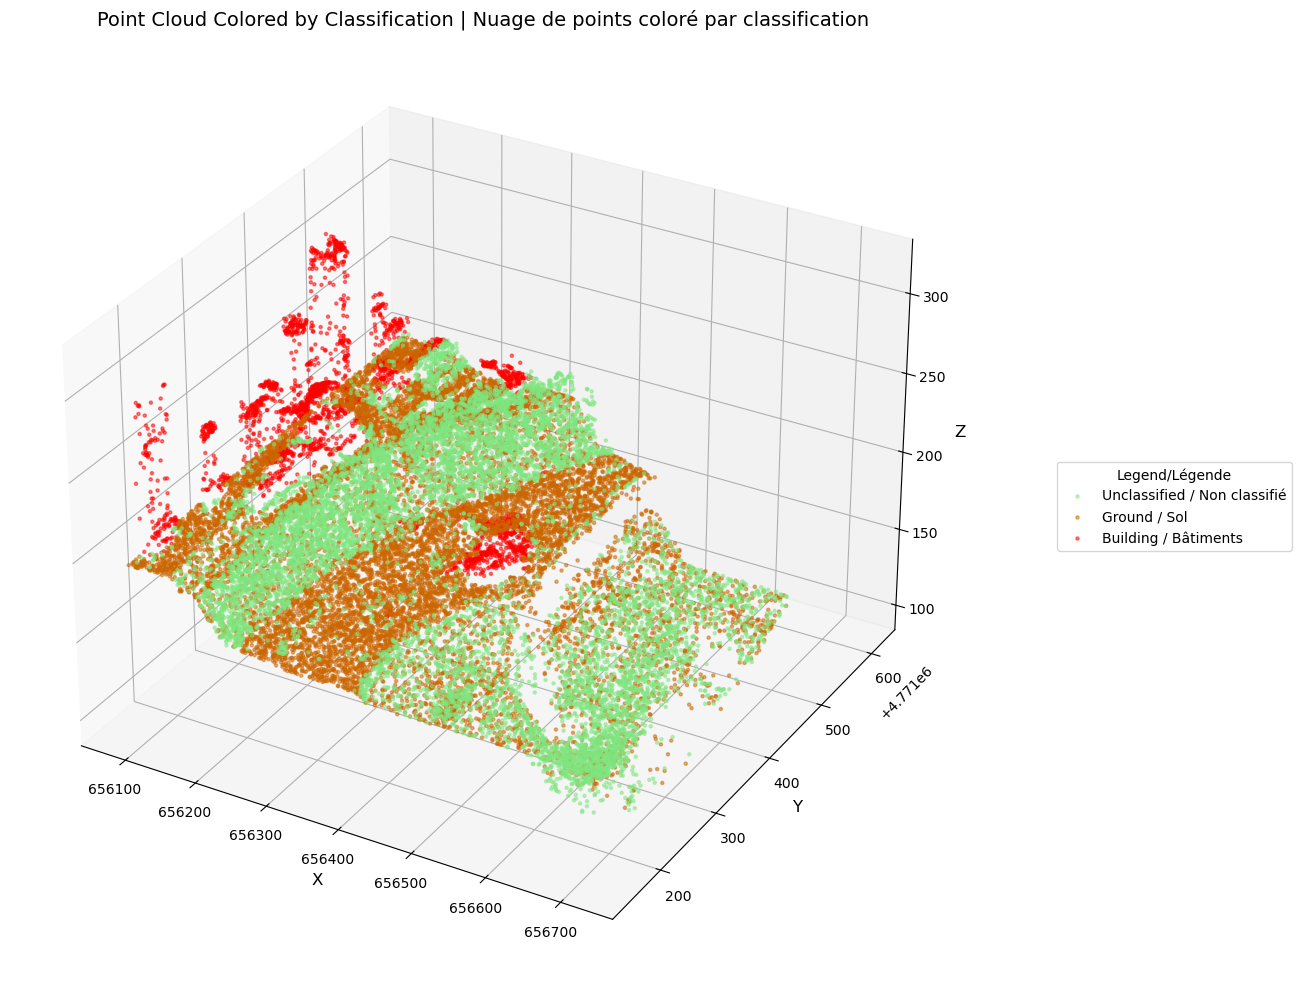

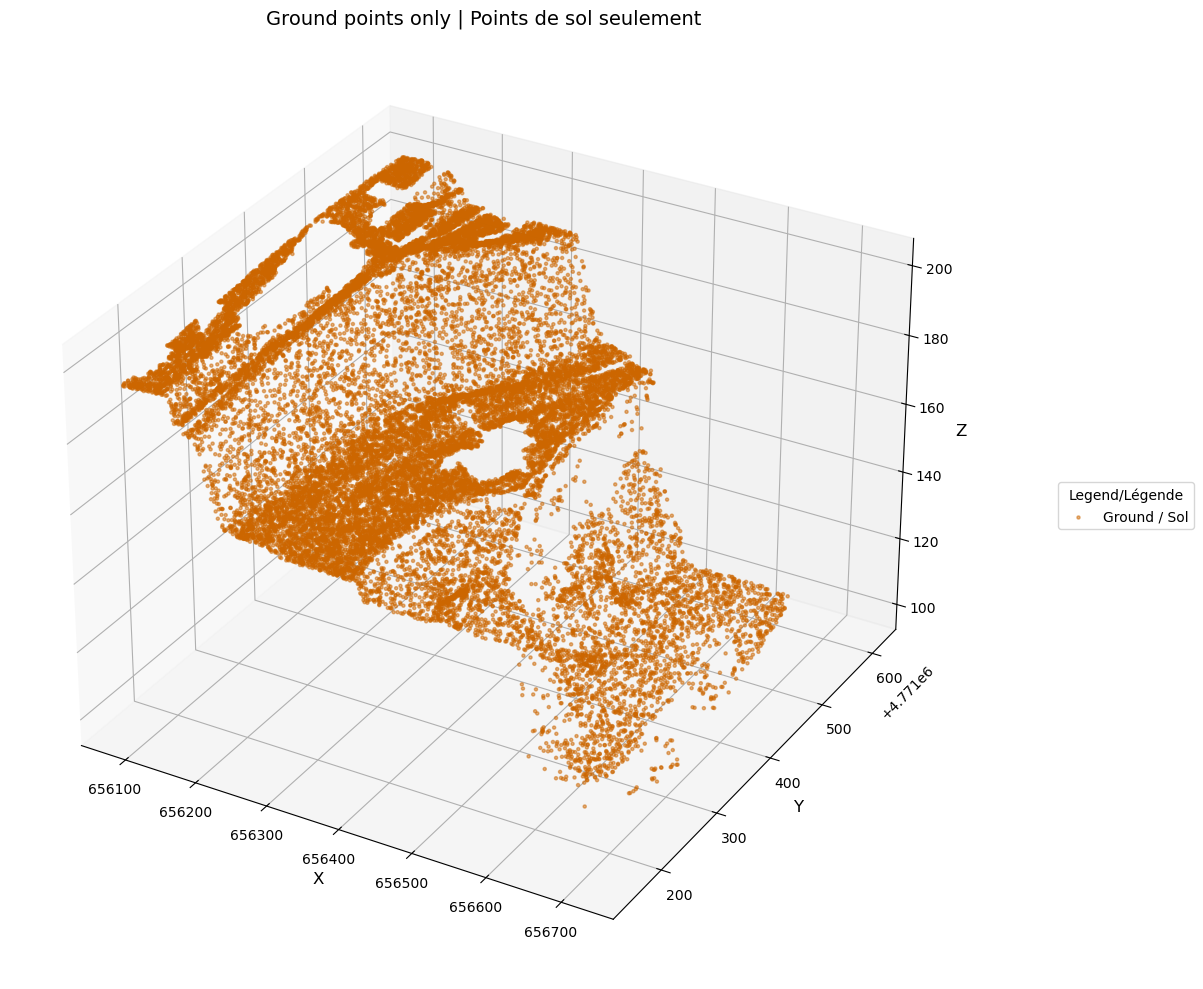

In [14]:
# Keep the points for classes: unclassified (1), ground (2), buildings (6), water (9)
pipeline_allpoints = create_read_pdal_pipeline(copc_laz, all_points_laz, bbox=aoi_bbox, classes=[1, 2, 6, 9])
pipeline_allpoints.execute()
points = pipeline_allpoints.arrays[0]
plot1 = create_plot('Point Cloud Colored by Classification | Nuage de points coloré par classification', points, max_points=25000)
plot1.show()

# Keep only ground (2) and water (9) points for DEM creation
pipeline_ground_points = create_read_pdal_pipeline(copc_laz, ground_laz, bbox=aoi_bbox, classes=[2, 9])
pipeline_ground_points.execute()
ground_points = pipeline_ground_points.arrays[0]
plot2 = create_plot('Ground points only | Points de sol seulement', ground_points, max_points=25000)
plot2.show()

## 6) Create the DEM in GeoTIFF Format

For this step, we use the `ground_points` object, which contains the array of points representing the surface. We pass this to the `create_dem_pipeline` method, which builds a pipeline to convert the points into a raster (DEM) format. To visualize the result, we generate a plot of the resulting raster.

Note: The output contains areas with no data (NoData). These correspond to regions where no ground or water points were available. If complete surface coverage is needed, tools like [`gdal_fillnodata`](https://gdal.org/en/stable/programs/gdal_fillnodata.html) can be used to interpolate and fill these gaps.

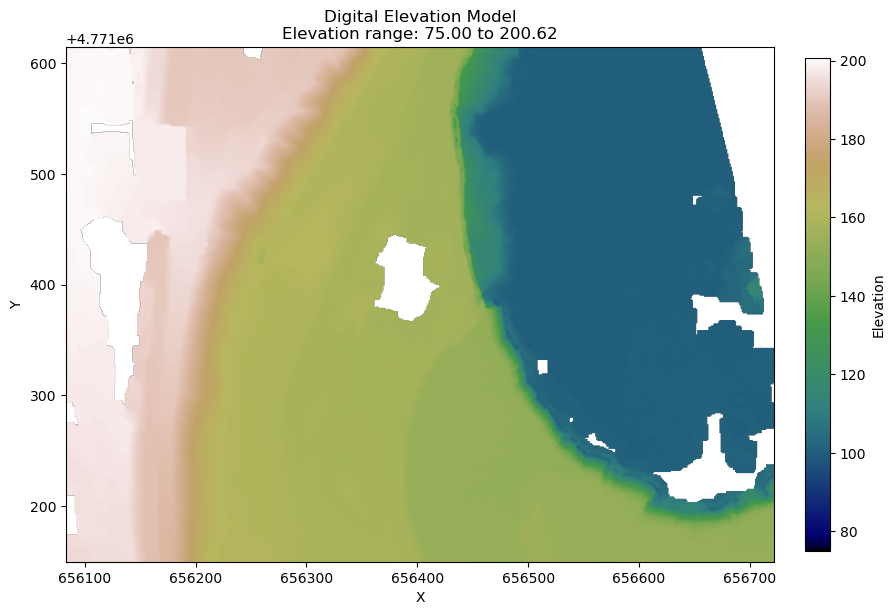

In [12]:
# Create a PDAL pipeline to generate a DEM from the filtered ground points array
dem_pipeline = create_dem_pipeline(ground_points)

# Execute the pipeline to generate and save the DEM as a GeoTIFF file
dem_pipeline.execute()

# Plot the resulting DEM
fig, ax = plot_dem('dem.tif', cmap = 'gist_earth')
plt.show()